# Home Loan Approval/Denial: Models, part C: XGBoost

#### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from xgboost import XGBClassifier, callback

In [4]:
# Local functions
from modeling_preparation import get_X_y

#### Auxiliary variables

In [5]:
filename_input = "data-hdma-eastbay-2019-2022-processed"

## Loading the processed data

In [6]:
X_train, X_test, y_train, y_test = get_X_y(filename_input, ohe_transform=False)

for col in list(X_train.select_dtypes(include=object).columns):
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

## XGBoost

In [ ]:
early_stop = callback.EarlyStopping(
    rounds=30,
    metric_name="aucpr",
    maximize=True,
    data_name="validation_0",
    save_best=True,
    min_delta=0.001,
)

clf = XGBClassifier(
    tree_method="hist",
    booster="dart",
    rate_drop=0.1,
    enable_categorical=True,
    eval_metric=["error", "error@0.2", "error@0.4", "error@0.6", "error@0.8", "aucpr"],
    objective="binary:logistic",
    callbacks=[early_stop],
    nthread=4,
)

gridcv = GridSearchCV(
    estimator=clf,
    param_grid={
        "n_estimators": [300],
        "max_depth": [6],
        "learning_rate": [0.8],
        "lambda": [0.01, 0.1, 1, 10]
    },
    n_jobs=1,
    verbose=4,
    cv=4,
).fit(X_train, y_train, eval_set=[(X_test, y_test)])

In [8]:
gridcv.best_params_

{'lambda': 1, 'learning_rate': 0.8, 'max_depth': 6, 'n_estimators': 300}

In [9]:
print(f'train score = {gridcv.score(X_train, y_train)}')
print(f'test score = {gridcv.score(X_test, y_test)}')

train score = 0.8069726229102329
test score = 0.8029826241619921


In [13]:
importances = pd.DataFrame(gridcv.best_estimator_.feature_importances_, gridcv.best_estimator_.feature_names_in_)
importances.columns = ['F']
importances.sort_values(by=['F'], ascending=False)

,F
debt_to_income_ratio,0.584916
property_value,0.094277
loan_type,0.079867
loan_purpose,0.073168
loan_to_value_ratio,0.040606
applicant_race,0.033108
loan_amount,0.032091
income,0.018033
applicant_ethnicity,0.015829
applicant_sex,0.014151


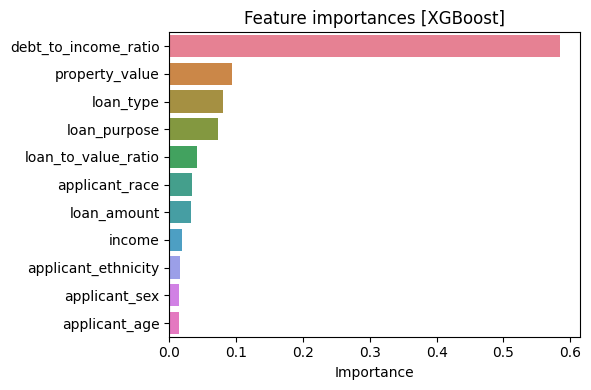

In [28]:
f, ax = plt.subplots(figsize=(6,4))
sns.barplot(importances.sort_values(by='F', ascending=False).T, orient='h', ax=ax)

ax.set_title('Feature importances [XGBoost]')
ax.set_xlabel('Importance')

plt.tight_layout()
plt.savefig('images/models-feat_importance.png', dpi=600)
plt.show()

In [ ]:
predictions = np.where(gridcv.predict(X_test) > 0.5, 1, 0)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.53      0.65     22501
           1       0.80      0.94      0.86     43280

    accuracy                           0.80     65781
   macro avg       0.81      0.74      0.76     65781
weighted avg       0.81      0.80      0.79     65781

